# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [48]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [49]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
from correlade import correlade
import distcorr

#Set random seed
np.random.seed(1606)

### 1. Import Vectors and Pre-Process them

In [50]:
# Import vec file
with open('AllVectorResults.lst', 'r') as file:
    text = file.read()

In [51]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [52]:
df.head()

,ID,Vector
0,MESH:D012559,"[0.01491615, -0.00155747, -0.30986652, 0.04035..."
1,MESH:D009404,"[3.82804424e-02, 1.29408345e-01, 3.75053808e-0..."
2,MESH:D001749,"[-0.01025235, 0.00664143, -0.30367315, 0.15593..."
3,MESH:D011471,"[-0.0130785, -0.02445601, -0.46697775, 0.13181..."
4,MESH:D008106,"[-0.06240484, 0.00166245, -0.5013923, 0.116841..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [93]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID,DirectEvidence
0,C046983,MESH:D054198,therapeutic
1,C112297,MESH:D006948,marker/mechanism
2,C112297,MESH:D012640,marker/mechanism
3,C039775,MESH:D004827,therapeutic
4,C425777,MESH:D006948,marker/mechanism


In [94]:
chem_dis.DiseaseID.nunique()

3191

In [95]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('MESH:', '')
# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('OMIM:', '')

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [96]:
id_list[:4]

['MESH:D012559', 'MESH:D009404', 'MESH:D001749', 'MESH:D011471']

In [97]:
len(id_list)

2970

In [98]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

# df1['Correlation'] = 1 # currently only have correlated in there

In [103]:
df1['Correlation'] = df1.DirectEvidence.map(lambda x: 0 if x == 'therapeutic' else 2)

In [105]:
df1.sample(13)

,ChemicalID,DiseaseID,DirectEvidence,DVec,CVec,Correlation
7990,D002762,MESH:D010146,therapeutic,"[3.53458934e-02, 1.41089112e-01, 2.37864740e-0...","[0.00133334, 0.14482908, -0.00980334, -0.07434...",0
5088,D014750,MESH:D007418,marker/mechanism,"[2.21003089e-02, 9.15838033e-02, 4.53496277e-0...","[0.02575784, -0.12796856, -0.45246562, 0.14957...",2
2979,D017239,MESH:D017563,marker/mechanism,"[0.0294158, 0.10534758, 0.06155422, -0.1112284...","[3.05738989e-02, 1.24812022e-01, 4.42865677e-0...",2
4334,D013749,MESH:D001943,marker/mechanism,"[-7.54089653e-03, 2.84954235e-02, -1.45941272e...","[-0.00484554, 0.04194254, -0.2854546, 0.007800...",2
3750,C059514,MESH:D007333,marker/mechanism,"[0.02338716, 0.09601952, 0.02362998, -0.079770...","[-0.05124907, 0.13055305, 0.01643063, -0.13386...",2
5725,D010634,MESH:D006529,marker/mechanism,"[0.00413939, 0.16396709, 0.01072616, -0.126804...","[0.02074566, 0.09746573, 0.02772122, -0.109691...",2
4724,D014451,MESH:D009205,marker/mechanism,"[0.02784503, 0.11853101, 0.0447395, -0.1132468...","[0.02183472, 0.10678482, 0.03412488, -0.086460...",2
7661,D012293,MESH:D008181,marker/mechanism,"[0.02943849, 0.11167332, 0.0409218, -0.0980009...","[0.01611397, 0.13506274, 0.06212807, -0.140545...",2
9298,C082360,MESH:D012640,marker/mechanism,"[0.03174636, 0.09961556, -0.22433679, -0.00831...","[1.82336681e-02, 9.57204401e-02, 3.57790105e-0...",2
914,D002220,MESH:D014277,therapeutic,"[-0.01447744, 0.10961439, -0.03909488, -0.0513...","[2.61190552e-02, 1.01711757e-01, 4.12642285e-0...",0


In [106]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [107]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# np.random.seed(1606)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':1}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  10035
Alert!
Alert!
Alert!
Alert!
(20071, 6)
(18576, 6)


In [108]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [120]:
print(len(df1[df1.DirectEvidence =='marker/mechanism']))
print(len(df1[df1.DirectEvidence =='therapeutic']))
print(len(df1[df1.DirectEvidence.isna()]))

5971
2723
9882


In [109]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DVec,CVec,Correlation
0,C049584,MESH:D001943,marker/mechanism,"[-0.00754089653, 0.0284954235, -0.145941272, -...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",2
1,C049584,MESH:D018270,marker/mechanism,"[0.01976116, 0.098279193, 0.0369541571, -0.089...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",2
2,C049584,MESH:D019457,marker/mechanism,"[0.03360923, 0.10056757, 0.05314376, -0.113913...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",2
3,C049584,MESH:D003110,marker/mechanism,"[0.00136586, 0.13832065, 0.02338981, -0.113038...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",2
4,C049584,MESH:D015179,marker/mechanism,"[-0.02237691, 0.07948194, -0.09784327, -0.0321...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",2


In [121]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [198]:
# Turn correlation into three options
# [1,0,0] --> neg corr
# [0,1,0] --> no corr
# [0,0,1] --> pos corr
# Note we can't be certain that the unrelated pairs are actually unrelated

df1['y'] = df1.Correlation.map(lambda x: [1,0,0] if x == 0 else ([0,1,0] if x == 1 else [0,0,1]))

In [199]:
df1.sample(1)

,index,ChemicalID,DiseaseID,DirectEvidence,DVec,CVec,Correlation,train,test,val,y
1738,2027,D005472,MESH:D016171,marker/mechanism,"[0.0451943986, 0.149554864, 0.0377507433, -0.1...","[0.0123879761, 0.102278464, 0.0492032096, -0.1...",2,True,False,False,"[0, 0, 1]"


In [200]:
# Now create np array of the y output
all_y = np.array(df1.y)

In [201]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (18576,)
X shape:  (18576, 400)


array([list([0, 0, 1])], dtype=object)

In [16]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [204]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  412
number of dis:  2516
247 83 82


In [205]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [206]:
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

In [207]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

11098 3826 3652


In [208]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

In [209]:
y_train[:1]

array([list([0, 0, 1])], dtype=object)

### 3. Establish NN Model

In [236]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(200, input_shape=(10620, 400), activation=tf.nn.relu),
#     keras.layers.Flatten(), 
#     tf.layers.flatten(inputs),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(10, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])
from keras.layers import Dense, Dropout, Flatten

model.add(keras.layers.Flatten())

In [237]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='categorical_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [238]:
# Pre-training, set up training params
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [239]:
# 3. Train
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

ValueError: Error when checking input: expected dense_76_input to have 3 dimensions, but got array with shape (11098, 400)

### ...and evaluate

In [141]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

4001/4001 [==============================]4001/4001 [==============================] - 0s 32us/step

Test accuracy: 0.5051237190702325


In [142]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  0     1  2  __all__
Actual                        
0          0   634  0      634
1          0  2021  0     2021
2          0  1346  0     1346
__all__    0  4001  0     4001


/home/colemai/anaconda3/lib/python3.6/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


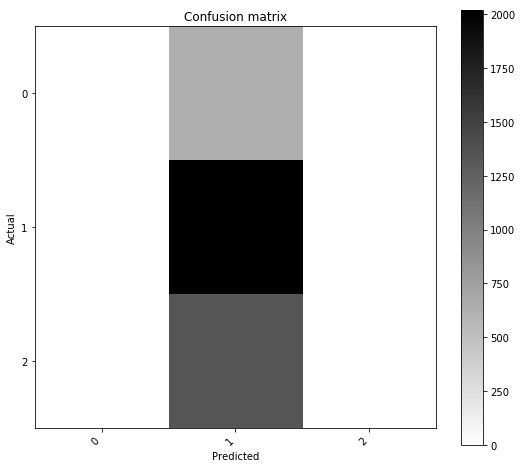

In [143]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [29]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8308373189078753


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [30]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [31]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [32]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [33]:
df_cd.head()

,# ChemicalName,ChemicalID,DiseaseName,DiseaseID,DirectEvidence
1,06-Paris-LA-66 protocol,C046983,Precursor Cell Lymphoblastic Leukemia-Lymphoma,MESH:D054198,therapeutic
71,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,Hyperkinesis,MESH:D006948,marker/mechanism
86,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,Seizures,MESH:D012640,marker/mechanism
135,"10,11-dihydro-10-hydroxycarbamazepine",C039775,Epilepsy,MESH:D004827,therapeutic
189,"10,11-dihydroxy-N-n-propylnorapomorphine",C425777,Hyperkinesis,MESH:D006948,marker/mechanism


In [34]:
test_set.head()

,index,ChemicalID,DiseaseID,DVec,CVec,Correlation,train,test,val,Predictions,RoundPredictions
504,508,D004317,MESH:D001943,"[-0.00754089653, 0.0284954235, -0.145941272, -...","[0.0052996, 0.09436312, 0.06031594, -0.1170692...",1,False,True,False,0.782367,1
505,509,D004317,MESH:D019457,"[0.03360923, 0.10056757, 0.05314376, -0.113913...","[0.0052996, 0.09436312, 0.06031594, -0.1170692...",1,False,True,False,0.258500,0
506,510,D004317,MESH:D007249,"[0.01034204, 0.13031472, 0.01779367, -0.105695...","[0.0052996, 0.09436312, 0.06031594, -0.1170692...",1,False,True,False,0.738379,1
507,511,D004317,MESH:D015674,"[0.02138487, 0.14707246, 0.01843957, -0.118100...","[0.0052996, 0.09436312, 0.06031594, -0.1170692...",1,False,True,False,0.555044,1
508,512,D004317,MESH:D009369,"[-0.01337378, 0.07777877, -0.06938379, -0.0139...","[0.0052996, 0.09436312, 0.06031594, -0.1170692...",1,False,True,False,0.552310,1


In [35]:
# Get ready for some memory-optimisation
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [36]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

0.04 MB
0.02 MB


In [37]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # these cols are memory intensive
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    if str(col) in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')
        
test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [38]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

# Create combined gofunc count col
test_set['sumGoFuncs'] = test_set.ChemGoFuncs + test_set.DisGoFuncs
test_set['prodGoFuncs'] = test_set.ChemGoFuncs * test_set.DisGoFuncs



In [70]:
# Create false pos and false neg col
test_set['false_pos'] = abs(test_set.RoundPredictions - test_set.Correlation).map(lambda x: 0 if x > 200 else x)
test_set['true_pos'] = (test_set.RoundPredictions + test_set.Correlation).map(lambda x: 1 if x==2 else 0)

In [71]:
test_set.sample(13)

,ChemicalID,DiseaseID,Correlation,train,test,val,Predictions,RoundPredictions,DiseaseName,# ChemicalName,ChemGoFuncs,DisGoFuncs,sumGoFuncs,prodGoFuncs,false_pos,true_pos
42191,D013752,MESH:D009205,1,False,True,False,0.217463,0,Myocarditis,Tetracycline,13,21,34,273,0,0
87590,D016578,MESH:D009395,1,False,True,False,0.491535,0,"Nephritis, Interstitial",Crack Cocaine,8,59,67,472,0,0
91455,D009151,MESH:D029424,1,False,True,False,0.654257,1,"Pulmonary Disease, Chronic Obstructive",Mustard Gas,13,216,229,2808,0,1
75729,D016578,MESH:D011297,1,False,True,False,0.543976,1,Prenatal Exposure Delayed Effects,Crack Cocaine,8,29,37,232,0,1
160827,C021751,MESH:D015812,0,False,True,False,0.095831,0,"Glaucoma, Angle-Closure",tanshinone,9,20,29,180,0,0
53443,D004317,MESH:D010493,1,False,True,False,0.097032,0,Pericarditis,Doxorubicin,23,7,30,161,0,0
131968,D016578,MESH:D014657,1,False,True,False,0.515549,1,Vasculitis,Crack Cocaine,8,81,89,648,0,1
73497,C086401,MESH:D006984,1,False,True,False,0.062695,0,Hypertrophy,pentabromodiphenyl ether,18,5,23,90,0,0
3535,D009151,MESH:D048629,1,False,True,False,0.169589,0,"Micronuclei, Chromosome-Defective",Mustard Gas,13,17,30,221,0,0
59123,D020123,MESH:D033461,1,False,True,False,0.230612,0,Hyperuricemia,Sirolimus,25,19,44,475,0,0


In [ ]:
# v=np.linspace(-1,1,10001)
# print (np.corrcoef(v,np.abs(v))[0,1], distcorr.distcorr(v,np.abs(v)))

In [ ]:
# Test data for distance correlation
data = [[4,10],[4,12],[6,13]]
zdf = pd.DataFrame(data,columns=['Name','Age'],dtype=np.int64)
type(zdf.Name[1])

In [ ]:
# correlade.dcorr(zdf)
zdf.head().corr()

In [72]:
#Distance Correlation
correlade.dcorr(test_set.sample(1300)[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']])

                 Correlation Predictions RoundPredictions ChemGoFuncs  \
Correlation                1    0.188923         0.102508   0.0427998   
Predictions         0.188923           1         0.828104    0.117136   
RoundPredictions    0.102508    0.828104                1   0.0521023   
ChemGoFuncs        0.0427998    0.117136        0.0521023           1   
DisGoFuncs         0.0953994    0.790543         0.744659   0.0173606   
sumGoFuncs         0.0915694    0.708864         0.673654    0.408123   
prodGoFuncs          0.09322    0.571465         0.540877    0.401007   
false_pos           0.259039    0.273393         0.328287    0.027043   

                 DisGoFuncs sumGoFuncs prodGoFuncs false_pos  
Correlation       0.0953994  0.0915694     0.09322  0.259039  
Predictions        0.790543   0.708864    0.571465  0.273393  
RoundPredictions   0.744659   0.673654    0.540877  0.328287  
ChemGoFuncs       0.0173606   0.408123    0.401007  0.027043  
DisGoFuncs                1

In [73]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr()

,Correlation,Predictions,RoundPredictions,ChemGoFuncs,DisGoFuncs,sumGoFuncs,prodGoFuncs,false_pos
Correlation,1.000000,0.170693,0.117550,-0.001071,0.026386,0.019070,0.013818,-0.256196
Predictions,0.170693,1.000000,0.841228,0.008825,0.619926,0.470424,0.114122,0.267114
RoundPredictions,0.117550,0.841228,1.000000,0.011549,0.554865,0.423458,0.103572,0.333286
ChemGoFuncs,-0.001071,0.008825,0.011549,1.000000,0.004361,0.662057,0.396091,-0.002486
DisGoFuncs,0.026386,0.619926,0.554865,0.004361,1.000000,0.752334,0.193820,0.297692
sumGoFuncs,0.019070,0.470424,0.423458,0.662057,0.752334,1.000000,0.406201,0.221471
prodGoFuncs,0.013818,0.114122,0.103572,0.396091,0.193820,0.406201,1.000000,0.031329
false_pos,-0.256196,0.267114,0.333286,-0.002486,0.297692,0.221471,0.031329,1.000000


In [74]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr(method='spearman')

,Correlation,Predictions,RoundPredictions,ChemGoFuncs,DisGoFuncs,sumGoFuncs,prodGoFuncs,false_pos
Correlation,1.000000,0.200273,0.117550,-0.055372,0.108739,0.066899,0.065940,-0.256196
Predictions,0.200273,1.000000,0.636502,-0.181567,0.828172,0.657033,0.616205,0.208711
RoundPredictions,0.117550,0.636502,1.000000,-0.053804,0.599887,0.576462,0.539401,0.333286
ChemGoFuncs,-0.055372,-0.181567,-0.053804,1.000000,-0.026726,0.388584,0.475111,-0.039825
DisGoFuncs,0.108739,0.828172,0.599887,-0.026726,1.000000,0.844446,0.824239,0.209844
sumGoFuncs,0.066899,0.657033,0.576462,0.388584,0.844446,1.000000,0.979443,0.203650
prodGoFuncs,0.065940,0.616205,0.539401,0.475111,0.824239,0.979443,1.000000,0.187917
false_pos,-0.256196,0.208711,0.333286,-0.039825,0.209844,0.203650,0.187917,1.000000


In [69]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'false_pos']].to_csv('predictions.csv', index=False)

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similary

In [ ]:
# df1.head()

In [ ]:
# Calculate out the cosine similarity and see if there's a difference between groups
def cosine_sim (row):
    return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# Compare cosine sim of correlated and uncorrelated groups
print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)